### This notebook has all the original code from Fooling nw intr. On top of that we have an added guided back prop module. However, subsequent calls to this class are failing throwing an error 'tried to call backward twice buffer already cleared, set retain_graph=True'.
### Running the code without calling the class object is working normally.
### An interesting observation is that the gcam output after being multiplied with img and the guided gradcam output are quite similar.

In [2]:
import os
import argparse
import numpy as np
import cv2
import torch
from torch.autograd import Variable
from torchvision import models
import matplotlib.pyplot as plt
from torch.autograd import Function
import torch.nn as nn
from torchvision import datasets, transforms
from keras import datasets as keras_datasets

Using TensorFlow backend.


In [3]:
NUM_CHANNELS = 1
PATCH_SIZE = 14 # it is 64 for 224x224 image
IMG_W = 28 # 224 originally
IMG_H = 28 # 224 originally
# MEANS = np.array([0.1307])
# STDS = np.array([0.3081])
MEANS = np.array([0.])
STDS = np.array([1.])

In [4]:
class Net(nn.Module):
    def __init__(self, features, num_classes, init_weights=True):
        super(Net, self).__init__()
        
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(4*4*50, 500),
            nn.ReLU(True),
            nn.Linear(500, num_classes)
        )
        
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        
        # x are the logits values
        return x 
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [5]:
# for name, module in model._modules.items():
#     print('name: ', name)
#     print('module: ',module)
#     print('\n')

In [6]:

# Compute the per channel clamp_min and clamp_max respectively
channel_clamp_min = (0 - MEANS) / STDS
channel_clamp_max = (1 - MEANS) / STDS

In [7]:
class FeatureExtractor:
    """ Class for extracting activations and
    registering gradients from targeted intermediate layers """
    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for name, module in self.model._modules.items():
            x = module(x)
            if name in self.target_layers:
                # Store the features and register hook to save gradients for the target layer
                x.register_hook(self.save_gradient)
                outputs += [x]
        return outputs, x


class ModelOutputs:
    """ Class for making a forward pass, and getting:
    1. The network output.
    2. Activations from intermediate targeted layers.
    3. Gradients from intermediate targeted layers. """
    def __init__(self, model, target_layers):
        self.model = model
        self.feature_extractor = FeatureExtractor(self.model.features, target_layers)

    def get_gradients(self):
        # Retrieve the saved gradients for the target layer
        return self.feature_extractor.gradients

    def __call__(self, x):
        target_activations, output = self.feature_extractor(x)
        output = output.view(output.size(0), -1)
        output = self.model.classifier(output)
        return target_activations, output


def preprocess_image(input_image):
    """
    This method normalizes the input image and converts it to a torch Variable
    :param input_image: The input image to be pre-processed
    :return: torch Variable of the normalized input image
    """
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    normalized_image = input_image.copy()[:, :, ::-1]
    for i in range(3):
        normalized_image[:, :, i] = normalized_image[:, :, i] - means[i]
        normalized_image[:, :, i] = normalized_image[:, :, i] / stds[i]
    normalized_image = \
        np.ascontiguousarray(np.transpose(normalized_image, (2, 0, 1)))
    normalized_image = torch.from_numpy(normalized_image)
    normalized_image.unsqueeze_(0)
    normalized_tensor = Variable(normalized_image, requires_grad=True).cuda()
    return normalized_tensor

# added by raj
def preprocess_image_one_ch(input_image):
    # use same values as in the transform.normalize method when the FMNIST model is trained
    mean = MEANS[0]
    std = STDS[0]
    normalized_image = input_image.copy()
    normalized_image = normalized_image.reshape(normalized_image.shape[0], normalized_image.shape[1], 1)
    
    normalized_image[:, :, 0] = normalized_image[:, :, 0] - mean
    normalized_image[:, :, 0] = normalized_image[:, :, 0] / std
    
    normalized_image = \
        np.ascontiguousarray(np.transpose(normalized_image, (2, 0, 1)))
    normalized_image = torch.from_numpy(normalized_image)
    normalized_image.unsqueeze_(0)
    normalized_tensor = Variable(normalized_image, requires_grad=True).cuda()
    return normalized_tensor

def show_cam_on_image(input_image, mask, filename="cam.png"):
    """
    Converts the mask to a heatmap and overlays it with the input image.
    :param input_image: input image
    :param mask: gradcam mask to be used as heatmap
    :param filename: output path to write the image overlayed with the mask
    :return:
    """
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(input_image)
    cam = cam / np.max(cam)
    cv2.imwrite(filename, np.uint8(255 * cam))


class GradCamAttack:
    """
    This class is responsible for creating a targeted adversarial patch such that the top predicted category is the
    target category and the Grad-CAM for the target category is hidden in the patch location.
    """
    def __init__(self, model, target_layer_names):
        self.model = model
        self.model.eval()
        self.model = model.cuda()
        self.criterion = torch.nn.CrossEntropyLoss().cuda()
        self.extractor = ModelOutputs(self.model, target_layer_names)
        self.relu = torch.nn.ReLU()

    def __call__(self, image_tensor, index, target_class_index, lr=.005, eps=0.007, lambda_val=0.05, attack_iters=750):
        print('\n\nOur adversarial patch attack:\n\n')
        print('Before attack, Predicted class:{}\tTarget class:{}\n\n'.format(index, target_class_index))

        # Clone the original image for computing the adversarial image with the patch
        adv_image_tensor = image_tensor.clone()

        # Initialize the perturbation tensor
        dl_dx_cumulative = torch.zeros_like(image_tensor)

        # Specify the top-left co-ordinates and the size for the patch and create the corresponding mask
        # The mask will have ones at the patch location pixels and zeros at all other pixels
        start_pos = (0, 0)
        #patch_size = 64
        patch_size = PATCH_SIZE
        mask = torch.zeros_like(image_tensor).cuda()
        mask.data[0, :, start_pos[1]:start_pos[1] + patch_size, start_pos[0]:start_pos[0] + patch_size] = 1.0

        # Means and std_devs used for pre-processing
#         means = np.array([0.485, 0.456, 0.406])
#         stds = np.array([0.229, 0.224, 0.225])
        
        # Compute the per channel clamp_min and clamp_max respectively
        channel_clamp_min = (0 - MEANS) / STDS
        channel_clamp_max = (1 - MEANS) / STDS

        loss_zero_counter = 0
        for i in range(attack_iters):
            adv_features, adv_output = self.extractor(adv_image_tensor)
            pred_index = np.argmax(adv_output.cpu().data.numpy())

            # Create a one-hot tensor for the target category
            one_hot = np.zeros((1, adv_output.size()[-1]), dtype=np.float32)
            one_hot[0][target_class_index] = 1
            one_hot = Variable(torch.from_numpy(one_hot), requires_grad=True)
            one_hot_tensor = torch.sum(one_hot.cuda() * adv_output)

            # Clear the gradients before loss computation
            self.model.features.zero_grad()
            self.model.classifier.zero_grad()

            # Compute the gradients of the loss with respect to the feature layer for the adversarial image
            dy_dz, = torch.autograd.grad(one_hot_tensor, adv_features[0],
                                         grad_outputs=torch.ones(one_hot_tensor.size()).cuda(),
                                         retain_graph=True, create_graph=True)
            dy_dz_sum = dy_dz.sum(dim=2).sum(dim=2)

            # Compute gradient weighted class activations for the perturbed image
            grad_weighted_feats = dy_dz_sum.unsqueeze(-1).unsqueeze(-1) * adv_features[0]
            gcam = grad_weighted_feats.sum(dim=1).squeeze(0)
            gcam = self.relu(gcam)

            # Normalize the gradcam tensor
            gcam = gcam / (gcam.sum() + 1e-10)
            
            print('gcam shape = ', gcam.shape)

            # Compute the loss for the patch location pixels in the gradcam tensor.
            # For a 224x224 image, the adversarial patch size is 64x64.
            # Since the gradcam tensor is 14x14 for VGG19 BN network, the corresponding gradcam patch size is 4x4
            
            gcam_loss = torch.sum(gcam[0:4, 0:4]).abs().cuda()
            gcam_loss = gcam_loss / 16.0

            # Add the cross entropy loss if target category is not the top predicted category
            if np.argmax(adv_output.cpu().data.numpy()) == target_class_index:
                xe_loss = 0.0
            else:
                xe_loss = self.criterion(adv_output, torch.tensor([target_class_index], dtype=torch.long).cuda())

            # We minimize both the gradcam loss and cross entropy loss
            total_loss = gcam_loss + (lambda_val * xe_loss)

            # Stop the attack once the loss is zero for 5 consecutive iterations
            if total_loss == 0.0:
                if loss_zero_counter > 5:
                    break
                else:
                    loss_zero_counter += 1
            else:
                loss_zero_counter = 0

            # Compute the gradient of the total loss with respect to the perturbed image
            dl_dx, = torch.autograd.grad(total_loss, adv_image_tensor)

            # Perform gradient ascent using the sign of dl_dx to compute the cumulative perturbation
            dl_dx_cumulative = dl_dx_cumulative - lr * torch.sign(dl_dx)
            adv_image_tensor = (1 - mask) * image_tensor.clone() + mask * dl_dx_cumulative

            # Clamp the adversarial image using per channel min and max respectively
            for c in range(NUM_CHANNELS):
                adv_image_tensor[:, c, :, :] = adv_image_tensor[:, c, :, :].clamp(channel_clamp_min[c],
                                                                                  channel_clamp_max[c])

            if i % 10 == 0:
                print('Iteration:{}\tGradCAM Loss:{:.3f}\tCE Loss:{:.3f}\ttotal_pert.mean:{:.3f}\tOrig index:{}'
                      '\tTarget index:{}\tPred index:{}'.format(i, gcam_loss, xe_loss, dl_dx_cumulative.abs().mean(),
                                                                index, target_class_index, pred_index))

        # Store the resulting adversarial image tensor
        res_adv_tensor = image_tensor.clone()
        res_adv_tensor.data = adv_image_tensor.data

        # Get the top predicted category of the resulting adversarial image tensor
        _, adv_output = self.extractor(res_adv_tensor)

        print('\n\nAfter attack, Original class: {}\tPredicted class: {}\tTarget class: {}'.
              format(index, adv_output[0].argmax(), target_class_index))

        # Denormalize the adversarial image
        adv_img = res_adv_tensor.data[0].cpu().numpy()
        adv_img = np.transpose(adv_img, (1, 2, 0))
        for i in range(NUM_CHANNELS):
            adv_img[:, :, i] = (adv_img[:, :, i] * STDS[i]) + MEANS[i]

        return adv_img, res_adv_tensor


class GradCamRegPatchAttack:
    """
    This class is responsible for creating a regular adversarial patch for a targeted attack.
    """
    def __init__(self, model, target_layer_names):
        self.model = model
        self.model.eval()
        self.model = model.cuda()
        self.criterion = torch.nn.CrossEntropyLoss().cuda()
        self.extractor = ModelOutputs(self.model, target_layer_names)

    def __call__(self, image_tensor, index, target_class_index, lr=.005, eps=0.007, lambda_val=0.05, attack_iters=750):
        print('\n\nRegular adversarial patch attack:\n\n')
        print('Before attack, Predicted class:{}\tTarget class:{}\n'.format(index, target_class_index))

        # Clone the original image for computing the perturbed adversarial image
        adv_image_tensor = image_tensor.clone() + torch.randn(image_tensor.size()).cuda() / 100

        # Initialize the perturbation tensor
        dl_dx_cumulative = torch.zeros_like(image_tensor)

        # Means and std_devs used for pre-processing
#         means = np.array([0.485, 0.456, 0.406])
#         stds = np.array([0.229, 0.224, 0.225])
        
        # Compute the per channel clamp_min and clamp_max respectively
        channel_clamp_min = (0 - MEANS) / STDS
        channel_clamp_max = (1 - MEANS) / STDS

        # Specify the top-left co-ordinates and the size for the patch and create the corresponding mask
        # The mask will have ones at the patch location pixels and zeros at all other pixels
        start_pos = (0, 0)
        patch_size = PATCH_SIZE
        mask = torch.zeros_like(image_tensor).cuda()
        mask.data[0, :, start_pos[1]:start_pos[1] + patch_size, start_pos[0]:start_pos[0] + patch_size] = 1.0

        loss_zero_counter = 0
        target_flip_counter = 0
        for i in range(attack_iters):
            _, adv_output = self.extractor(adv_image_tensor)
            pred_index = np.argmax(adv_output.cpu().data.numpy())

            self.model.features.zero_grad()
            self.model.classifier.zero_grad()

            # Stop the attack once the target category is reached for 5 consecutive attack iterations
            if i > 250 and pred_index == target_class_index:
                if target_flip_counter > 5:
                    break
                else:
                    target_flip_counter += 1
            else:
                target_flip_counter = 0

            xe_loss = self.criterion(adv_output, torch.tensor([target_class_index], dtype=torch.long).cuda())

            # Stop the attack once the loss is zero for 5 consecutive attack iterations
            if xe_loss == 0.0:
                if loss_zero_counter > 5:
                    break
                else:
                    loss_zero_counter += 1
            else:
                loss_zero_counter = 0

            # Compute the gradient of the total loss with respect to the perturbed image
            dl_dx, = torch.autograd.grad(xe_loss, adv_image_tensor)

            # Perform gradient ascent using the sign of dl_dx to compute the cumulative perturbation
            dl_dx_cumulative = dl_dx_cumulative - lr * torch.sign(dl_dx)
            adv_image_tensor = image_tensor.clone() * (1 - mask) + dl_dx_cumulative * mask

            # Clamp the adversarial image using per channel min and max respectively
            for c in range(NUM_CHANNELS):
                adv_image_tensor[:, c, :, :] = adv_image_tensor[:, c, :, :].clamp(channel_clamp_min[c],
                                                                                  channel_clamp_max[c])

            if i % 10 == 0:
                print('Iteration:{}\tCE Loss:{:.3f}\ttotal_pert.mean:{:.3f}\tOrig index:{}\tTarget index:{}'
                      '\tPred index:{}'.format(i, xe_loss, dl_dx_cumulative.abs().mean(),
                                               index, target_class_index, pred_index))

        # Store the resulting adversarial image tensor
        res_adv_tensor = image_tensor.clone()
        res_adv_tensor.data = adv_image_tensor.data

        # Get the top predicted category of the resulting adversarial image tensor
        _, adv_output = self.extractor(res_adv_tensor)

        print('\n\nAfter attack, Original class: {}\tPredicted class: {}\tTarget class: {}'.
              format(index, adv_output[0].argmax(), target_class_index))

        # Denormalize the adversarial image
        adv_img = res_adv_tensor.data[0].cpu().numpy()
        adv_img = np.transpose(adv_img, (1, 2, 0))
        for i in range(NUM_CHANNELS):
            adv_img[:, :, i] = (adv_img[:, :, i] * STDS[i]) + MEANS[i]

        return adv_img, res_adv_tensor


class GradCam:
    """
    This class computes the Grad-CAM mask for the specified index.
    """
    def __init__(self, model, target_layer_names):
        self.model = model
        self.model.eval()
        self.model = model.cuda()
        self.extractor = ModelOutputs(self.model, target_layer_names)

    def __call__(self, image_tensor, index=None):
        features, output = self.extractor(image_tensor)

        if index is None:
            index = np.argmax(output.cpu().data.numpy())

        # Compute the one-hot tensor corresponding to the index
        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = Variable(torch.from_numpy(one_hot), requires_grad=True)
        one_hot = torch.sum(one_hot.cuda() * output)

        self.model.features.zero_grad()
        self.model.classifier.zero_grad()
        one_hot.backward(retain_graph=True)

        # Get the gradients and features to compute Grad-CAM
        grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()
        target = features[-1]
        target = target.cpu().data.numpy()[0, :]

        weights = np.mean(grads_val, axis=(2, 3))[0, :]
        cam = np.zeros(target.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * target[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (IMG_W, IMG_W))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

class GuidedBackpropReLU(Function):

    def forward(self, input_tensor):
        positive_mask = (input_tensor > 0).type_as(input_tensor)
        output = torch.addcmul(torch.zeros(input_tensor.size()).type_as(input_tensor), input_tensor, positive_mask)
        self.save_for_backward(input_tensor, output)
        return output

    def backward(self, grad_output):
        input_tensor, output = self.saved_tensors
        grad_input = None

        positive_mask_1 = (input_tensor > 0).type_as(grad_output)
        positive_mask_2 = (grad_output > 0).type_as(grad_output)
        grad_input = torch.addcmul(torch.zeros(input_tensor.size()).
                                   type_as(input_tensor), torch.addcmul(torch.zeros(input_tensor.size()).
                                        type_as(input_tensor), grad_output, positive_mask_1), positive_mask_2)

        return grad_input

class GuidedBackpropReLUModel:
    def __init__(self, model, use_cuda):
        self.model = model
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        # replace ReLU with GuidedBackpropReLU
        for idx, module in self.model.features._modules.items():
            if module.__class__.__name__ == 'ReLU':
                self.model.features._modules[idx] = GuidedBackpropReLU()

    def forward(self, input_tensor):
        return self.model(input_tensor)

    def __call__(self, input_tensor, index = None):
        if self.cuda:
            output = self.forward(input_tensor.cuda())
        else:
            output = self.forward(input_tensor)

        if index == None:
            index = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype = np.float32)
        one_hot[0][index] = 1
        one_hot = Variable(torch.from_numpy(one_hot), requires_grad = True)
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)

        # self.model.features.zero_grad()
        # self.model.classifier.zero_grad()
        
        #one_hot.backward(retain_variables=True)
        one_hot.backward(retain_graph=True)

        output = input_tensor.grad.cpu().data.numpy()
        output = output[0,:,:,:]

        return output
    
class GuidedGradCam:
    """
    This class computes the Guided Grad-CAM mask for the specified index.
    """
    def __init__(self, model, target_layer_names):
        self.model = model
        self.model.eval()
        self.model = model.cuda()
        self.extractor = ModelOutputs(self.model, target_layer_names)

    def __call__(self, image_tensor, index=None):
        features, output = self.extractor(image_tensor)

        if index is None:
            index = np.argmax(output.cpu().data.numpy())

        # Means and std_devs used for pre-processing
#         means = np.array([0.485, 0.456, 0.406])
#         stds = np.array([0.229, 0.224, 0.225])
        
        # Compute the one-hot tensor corresponding to the index
        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = Variable(torch.from_numpy(one_hot), requires_grad=True)
        one_hot = torch.sum(one_hot.cuda() * output)

        self.model.features.zero_grad()
        self.model.classifier.zero_grad()
        one_hot.backward(retain_graph=True)

        # Get the gradients and features to compute Grad-CAM
        grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()
        target = features[-1]
        target = target.cpu().data.numpy()[0, :]

        weights = np.mean(grads_val, axis=(2, 3))[0, :]
        cam = np.zeros(target.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * target[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (IMG_W, IMG_H))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        
        # Gradcam ends here. Below additional code is added to produce guided grad-cam
        img = image_tensor.data[0].cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
#         for i in range(3):
#             img[:, :, i] = (img[:, :, i] * stds[i]) + means[i]
        cam_heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
        cam_heatmap = cv2.cvtColor(cam_heatmap, cv2.COLOR_BGR2RGB)
        cam = np.float32(cam.reshape((28, 28, 1))) * np.float32(img)
        cam = 255 * cam / np.max(cam)
        cam = np.uint8(cam)
        
        gb_viz -= np.min(gb_viz)
        gb_viz /= gb_viz.max()
        img_int = (gb_viz * 255.).astype(int).reshape(img.shape[:2])

        gd_gb = gb_viz * cam
        img_int = (gd_gb * 255.).astype(int).reshape(img.shape[:2])

        img_int = img_int/float(np.amax(img_int))

        return cam


def forward_inference(model, input_tensor):
    """
    Computes forward inference on the input image tensor and
    returns the top prediction index and probability
    :param model:
    :param input_tensor:
    :return:
    """
    output = model(input_tensor)
    index = np.argmax(output.cpu().data.numpy())
    index_prob = torch.nn.functional.softmax(output)[0][index]
    return index, index_prob


def get_args():

    if not torch.cuda.is_available():
        print("CUDA not available. Exiting.")
        exit()
    print("Using GPU for acceleration")

    parser = argparse.ArgumentParser()
    parser.add_argument('--image-path', type=str, default='./examples/ILSVRC2012_val_00008855.JPEG',
                        help='Input image path')
    parser.add_argument('--result-dir', type=str, default='./results', help='Path to store the results')
    return parser.parse_args()

In [8]:
# taken from http://localhost:8890/notebooks/pytorch-cw2/torch_fmnist_train_v2.ipynb
"""
torch.nn.Conv2d(in_channels, out_channels, kernel_size, 
stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
"""

def make_layers(cfg, in_channels, kernel_size, stride, padding, batch_norm=False):
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=kernel_size, padding=padding)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


"""
Refer VGG19_bn configurationh here: 
https://github.com/pytorch/vision/blob/76702a03d6cc2e4f431bfd1914d5e301c07bd489/torchvision/models/vgg.py#L63
"""
cfgs = {
    #'E': [64, 64, 'M',128, 128, 'M',256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M',512, 512, 512, 512, 'M'],
    'E': [20, 'M', 50, 'M']
}

model_layers = make_layers(cfgs['E'],in_channels=1, kernel_size=5, stride=1, padding=0, batch_norm=False)

# Main method

In [9]:
""" python gradcam_targeted_patch_attack.py --image-path <path_to_image> --result-dir <path_to_result_dir>
1. Loads an image with opencv.
2. Preprocesses it for VGG19 and converts to a pytorch variable.
3. Makes a forward pass to find the category index with the highest score,
and computes intermediate activations.
Makes the visualization. """

' python gradcam_targeted_patch_attack.py --image-path <path_to_image> --result-dir <path_to_result_dir>\n1. Loads an image with opencv.\n2. Preprocesses it for VGG19 and converts to a pytorch variable.\n3. Makes a forward pass to find the category index with the highest score,\nand computes intermediate activations.\nMakes the visualization. '

In [10]:
# args = get_args()
image_path = './examples/ILSVRC2012_val_00008855.JPEG' #Input image path
result_dir = './results' #Path to store the results

use_cuda = True

# Setting the seed for reproducibility for demo
# Comment the below 4 lines for the target category to be random across runs
np.random.seed(1)
torch.manual_seed(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False




In [11]:
NUM_CLASSES = 10

pretrained_model = "model/fmnist/v2/fmnist_cnn.pt"
# Initialize the network
model = Net(model_layers, num_classes=NUM_CLASSES).cuda()

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

Net(
  (features): Sequential(
    (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=800, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=500, out_features=10, bias=True)
  )
)

In [12]:
# Can work with any model, but it assumes that the model has a feature method,
# and a classifier method, as in the VGG models in torchvision.
gradcam_attack = GradCamAttack(model, target_layer_names=["4"])


In [13]:
#gradcam_reg_patch_attack = GradCamRegPatchAttack(model=models.vgg19_bn(pretrained=True), target_layer_names=["51"])
gradcam_reg_patch_attack = GradCamRegPatchAttack(model, target_layer_names=["4"])
#gradcam = GradCam(model=models.vgg19_bn(pretrained=True), target_layer_names=["51"])
gradcam = GradCam(model, target_layer_names=["4"])

#pretrained_vgg_net = models.vgg19_bn(pretrained=True).cuda()


#pretrained_vgg_net = pretrained_vgg_net.eval()

#image_name = image_path.split('/')[-1].split('.')[0]
#print('image_name ',image_name)

In [14]:
# Create result directory if it doesn't exist
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

# Read the input image and preprocess to a tensor
# img = cv2.imread(image_path, 1)
# img = np.float32(cv2.resize(img, (224, 224))) / 255
(x_train, y_train) ,(x_test, y_test) = keras_datasets.fashion_mnist.load_data()

# directory = './data/fmnist'

# IS_DATA_READY = True
# assert(IS_DATA_READY == True)

# x_train = np.load(directory + '/x_train.npy')
# y_train = np.load(directory + '/y_train.npy')
# x_test = np.load(directory + '/x_test.npy')
# y_test = np.load(directory + '/y_test.npy')

In [15]:
np.where(y_train==5)[0][0:20]

array([  8,   9,  12,  13,  30,  36,  43,  60,  62,  63,  82, 116, 120,
       121, 133, 155, 172, 173, 177, 192])

In [16]:
chosen_index = 8
img_sample = x_train[chosen_index]/255
y_train[chosen_index]

5

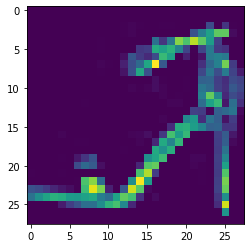

In [17]:
plt.imshow(img_sample)

In [18]:
#preprocessed_img = preprocess_image(img)
preprocessed_img = preprocess_image_one_ch(img_sample).float()

# img_sample = img_sample.reshape(1,28,28,1)
# img_sample = np.transpose(img_sample, (0,3,1,2))
# preprocessed_img = torch.from_numpy(img_sample).float().cuda()
# preprocessed_img = Variable(preprocessed_img, requires_grad=True).cuda()

In [19]:
print(preprocessed_img.shape)

torch.Size([1, 1, 28, 28])


In [20]:
print(np.min(img_sample))
print(np.max(img_sample))

0.0
1.0


In [21]:
# Get the original prediction index and the corresponding probability
orig_index, orig_prob = forward_inference(model, preprocessed_img)
print('Original index: {} and original probability: {}'.format(orig_index, orig_prob))


Original index: 5 and original probability: 0.9999725818634033


/scratch/user/raj_vardhan/.conda/envs/tf-gpu-env/lib/python3.6/site-packages/ipykernel_launcher.py:515: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [22]:

# Pick a random target from the remaining NUM_CLASSES-1 categories excluding the original prediction
list_of_idx = np.delete(np.arange(NUM_CLASSES), orig_index)
rand_idx = np.random.randint(NUM_CLASSES-1)
target_index = list_of_idx[rand_idx]
print('target index is ', target_index)

target index is  6


In [ ]:
# Compute the regular adv patch attack image and the corresponding GradCAM
reg_patch_adv_img, reg_patch_adv_tensor = gradcam_reg_patch_attack(preprocessed_img, orig_index, target_index)
reg_patch_pred_index, reg_patch_pred_prob = forward_inference(model,preprocess_image_one_ch(reg_patch_adv_img[:, :, ::-1]))

image_name = "my_img"
cv2.imwrite(os.path.join(result_dir, image_name + '_reg_adv_patch_image.png'),
            np.uint8(255 * np.clip(reg_patch_adv_img[:, :, ::-1], 0, 1)))



In [ ]:
plt.imshow(reg_patch_adv_img.reshape(28,28))

In [ ]:
# Generate the GradCAM heatmap for the target category using the regular patch adversarial image
reg_patch_adv_mask = gradcam(reg_patch_adv_tensor, target_index)
show_cam_on_image(np.clip(reg_patch_adv_img[:, :, ::-1], 0, 1), reg_patch_adv_mask,
                  filename=os.path.join(result_dir, image_name + '_reg_adv_patch_gcam.JPEG'))


In [ ]:
plt.imshow(reg_patch_adv_mask)

In [ ]:

# Compute the adv patch attack using our method and the corresponding GradCAM
# our_patch_adv_tensor has shape: torch.Size([1, 3, 224, 224])
# our_patch_adv_img has shape: (224, 224, 3)
our_patch_adv_img, our_patch_adv_tensor = gradcam_attack(preprocessed_img, orig_index, target_index)
our_patch_pred_index, our_patch_pred_prob = forward_inference(model,
                                                              preprocess_image_one_ch(our_patch_adv_img[:, :, ::-1]))
cv2.imwrite(os.path.join(result_dir, image_name + '_our_adv_patch_image.png'),
            np.uint8(255 * np.clip(our_patch_adv_img[:, :, ::-1], 0, 1)))

# Generate the GradCAM heatmap for the target category using our patch adversarial image
mask_adv_ = gradcam(our_patch_adv_tensor, target_index)
show_cam_on_image(np.clip(our_patch_adv_img[:, :, ::-1], 0, 1), mask_adv_,
                  filename=os.path.join(result_dir, image_name + '_our_adv_patch_gcam.JPEG'))


In [ ]:
# Generate the GradCAM heatmap for the target category using our patch adversarial image
mask_adv_ = gradcam(our_patch_adv_tensor, target_index)

In [ ]:
cam = mask_adv_
plt.imshow(cam)

In [ ]:
# Gradcam ends here. Below additional code is added to produce guided grad-cam

image_tensor = our_patch_adv_tensor

img = image_tensor.data[0].cpu().numpy()
img = np.transpose(img, (1, 2, 0))
#         for i in range(3):
#             img[:, :, i] = (img[:, :, i] * stds[i]) + means[i]
cam_heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
plt.imshow(cam_heatmap)

In [ ]:
cam_heatmap = cv2.cvtColor(cam_heatmap, cv2.COLOR_BGR2RGB)
plt.imshow(cam_heatmap)

In [ ]:
print(cam.shape)
print(img.shape)

cam = np.float32(cam.reshape((28, 28, 1))) * np.float32(img)
cam = 255 * cam / np.max(cam)
cam = np.uint8(cam)

# gb_viz -= np.min(gb_viz)
# gb_viz /= gb_viz.max()
# img_int = (gb_viz * 255.).astype(int).reshape(img.shape[:2])

# gd_gb = gb_viz * cam
# img_int = (gd_gb * 255.).astype(int).reshape(img.shape[:2])

# img_int = img_int/float(np.amax(img_int))

print(preprocessed_img.shape)
print(our_patch_adv_img.shape)
print(our_patch_adv_tensor.shape)

# Generate grad cam of original clean sample for true class

In [23]:
# Generate the GradCAM heatmap for the original class
mask_orig = gradcam(preprocessed_img, orig_index)

In [24]:
type(mask_orig)

numpy.ndarray

In [ ]:
cam = mask_orig
plt.imshow(cam)

In [ ]:
cam.shape

In [ ]:
image_tensor = preprocessed_img

img = image_tensor.data[0].cpu().numpy()
img = np.transpose(img, (1, 2, 0))

In [ ]:
img -= np.min(img)
img /= img.max()

In [ ]:
print(img.shape)
print(cam.shape)

print(np.max(cam))
print(np.min(cam))

print(np.max(img))
print(np.min(img))

In [ ]:
cam = np.float32(cam.reshape((28, 28, 1))) * np.float32(img)
cam = 255 * cam / np.max(cam)


In [ ]:
type(cam[0,0,0])

In [ ]:
cam = np.uint8(cam)

In [ ]:
plt.imshow(cam.reshape(28,28))

In [ ]:

# input_gb = Variable(preprocessed_img, requires_grad = True)

# gb_model = GuidedBackpropReLUModel(model, use_cuda=use_cuda)
# gb = gb_model(input_gb, orig_index)

# print(gb.shape)
# gb_tr = np.transpose(gb, (1,2,0))
# plt.imshow(gb_tr.reshape(28,28), cmap='gray')

# mean = 0.1307
# std = 0.3081
# gb_scaled = (gb_tr + mean)* std

# plt.imshow(gb_scaled.reshape(28,28))

In [ ]:
# input_gb = Variable(reg_patch_adv_tensor, requires_grad = True)

# gb_model = GuidedBackpropReLUModel(model, use_cuda=use_cuda)
# gb = gb_model(input_gb, orig_index)

# print(gb.shape)
# gb_tr = np.transpose(gb, (1,2,0))
# plt.imshow(gb_tr.reshape(28,28), cmap='gray')

In [ ]:
# gb = gb_model(input_gb, orig_index)

# print(gb.shape)
# gb_tr = np.transpose(gb, (1,2,0))
# plt.imshow(gb_tr.reshape(28,28), cmap='gray')

In [ ]:
# input_gb = Variable(reg_patch_adv_tensor, requires_grad = True)

# gb_model = GuidedBackpropReLUModel(model, use_cuda=use_cuda)
# gb = gb_model(input_gb, orig_index)

# print(gb.shape)
# gb_tr = np.transpose(gb, (1,2,0))
# plt.imshow(gb_tr.reshape(28,28), cmap='gray')

In [ ]:
input_gb = Variable(preprocessed_img, requires_grad = True)
output = model(input_gb)
index = target_index
one_hot = np.zeros((1, output.size()[-1]), dtype = np.float32)
one_hot[0][index] = 1
one_hot = Variable(torch.from_numpy(one_hot), requires_grad = True)
one_hot = torch.sum(one_hot.cuda() * output)

In [ ]:
one_hot

In [ ]:
one_hot.backward(retain_graph=True)
output = input_gb.grad.cpu().data.numpy()

In [ ]:
output.shape

In [ ]:
output = output[0,:,:,:]

In [ ]:
plt.imshow(output[0],cmap='gray')

In [ ]:
output.shape

In [ ]:
gb_viz = np.transpose(output, (1,2,0))

In [ ]:
print(gb_viz.shape)
print(cam.shape)
print(np.min(gb_viz))
print(np.max(gb_viz))

print(np.min(cam))
print(np.max(cam))

In [ ]:
gb_viz -= np.min(gb_viz)
gb_viz /= np.max(gb_viz)
gd_gb = gb_viz * cam

In [ ]:
print(np.min(gd_gb))
print(np.max(gd_gb)) # will be between 0 and 255

In [ ]:
img_int = (gd_gb * 255.).astype(int).reshape(img.shape[:2])
img_int = img_int/float(np.amax(img_int))
print(img_int.shape)

In [ ]:
plt.imshow(img_int)

# Here, we will load the explanation based model we trained for the class index 6 and see if it is able to correctly predict interpretations generated here

## interpretation generation code: http://localhost:8889/notebooks/pytorch-cw2/torch_fmnist_intr_train_v1.ipynb#

In [ ]:
# Load the explanation based model
NUM_CLASSES_EXP = 2 
class_ind = 6
model_dir = 'data/defender/fmnist/exp_model_data/for_target/' + str(class_ind) + '/model'
pretrained_exp_model = model_dir+"/exp_model.pt"

exp_model = Net(model_layers, num_classes=NUM_CLASSES_EXP).cuda()

# Load the pretrained model
exp_model.load_state_dict(torch.load(pretrained_exp_model))

# Set the model in evaluation mode. In this case this is for the Dropout layers
exp_model.eval()


In [ ]:
np.max(cam)

In [ ]:
input_intr = cam
input_intr = input_intr/255.
input_intr = input_intr.reshape(-1,28,28,1)
input_intr = np.transpose(input_intr, (0,3,1,2))

print('input_intr.shape',input_intr.shape) #(1, 1, 28, 28)

input_intr_tensor = torch.from_numpy(input_intr)
print('input_intr_tensor.shape: ', input_intr_tensor.shape)

input_intr_tensor = input_intr_tensor.float().cuda()

intr_pred = exp_model(input_intr_tensor)
index = np.argmax(intr_pred.cpu().data.numpy())
index_prob = torch.nn.functional.softmax(intr_pred)[0][index]

print('Classification: {} with probability:{}'.format(index, index_prob))

In [ ]:
torch.max(input_intr_tensor)

In [ ]:
torch.min(input_intr_tensor)